Template Image Info:
Shape: (160, 224, 192)
Data Type: float64
Min Value: 0.0
Max Value: 8364.0


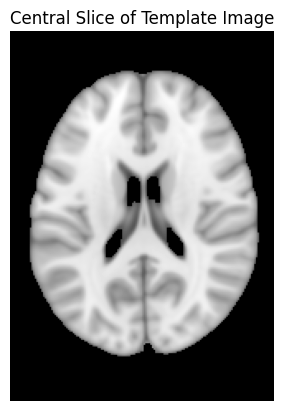

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt

template_path = '/NFS/Wu/tigerbx-main/tigerbx/template/MNI152_T1_1mm_brain.nii.gz'

# 載入 template 影像
template_img = nib.load(template_path)
template_data = template_img.get_fdata()

# 顯示影像的基本資訊
print("Template Image Info:")
print("Shape:", template_data.shape)
print("Data Type:", template_data.dtype)
print("Min Value:", template_data.min())
print("Max Value:", template_data.max())

# 顯示影像的中央切片（在z軸上取中央切片）
central_slice = template_data[:, :, template_data.shape[2] // 2]

# 使用 matplotlib 繪製切片
plt.imshow(central_slice.T, cmap='gray', origin='lower')
plt.title("Central Slice of Template Image")
plt.axis('off')
plt.show()


In [2]:
import os
import nibabel as nib
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def load_nii_files(path):
    """載入指定路徑下的所有 NIfTI 檔案。"""
    nii_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.nii') or f.endswith('.nii.gz')]
    nii_files.sort()  # 按檔名排序
    return nii_files

def normalize_image(data):
    """正規化影像數據到 [0, 1] 範圍。"""
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def mutual_information(fixed_data, moving_data, bins=256):
    """計算MI。"""
    mi_values = []
    for i in range(fixed_data.shape[2]):  # 假設影像是3D的
        fixed_slice = fixed_data[:, :, i]
        moving_slice = moving_data[:, :, i]
        hist_2d, _, _ = np.histogram2d(fixed_slice.ravel(), moving_slice.ravel(), bins=bins)
        pxy = hist_2d / np.sum(hist_2d)  # 聯合概率分佈
        px = np.sum(pxy, axis=1)  # 固定影像的概率分佈
        py = np.sum(pxy, axis=0)  # 移動影像的概率分佈
        px_py = px[:, None] * py[None, :]  # 獨立分佈
        nz = pxy > 0  # 非零值位置
        mi_values.append(np.sum(pxy[nz] * np.log(pxy[nz] / px_py[nz])))
    return np.mean(mi_values)

def calculate_metrics(moving_img, fixed_img):
    """計算PSNR, SSIM, MI。"""
    moving_data = normalize_image(moving_img.get_fdata())
    fixed_data = normalize_image(fixed_img.get_fdata())
    
    # PSNR
    psnr_value = psnr(fixed_data, moving_data, data_range=1)  # 因為已正規化，範圍設為 1
    
    # SSIM
    ssim_value = ssim(fixed_data, moving_data, data_range=1)
    
    # MI
    mi_value = mutual_information(fixed_data, moving_data)
    
    return psnr_value, ssim_value, mi_value

def compare_alignment(template_path, rigid_path, affine_path, registration_path, fusemorph_path):
    """批次比較三種對位方式的影像，並計算平均結果。"""
    template_img = nib.load(template_path)
    
    # 讀取每種對位方式的影像檔案
    rigid_files = load_nii_files(rigid_path)
    affine_files = load_nii_files(affine_path)
    registration_files = load_nii_files(registration_path)
    fusemorph_files = load_nii_files(fusemorph_path)


    results = {
        'rigid': {'psnr': [], 'ssim': [], 'mi': []},
        'affine': {'psnr': [], 'ssim': [], 'mi': []},
        'registration': {'psnr': [], 'ssim': [], 'mi': []},
        'fusemorph': {'psnr': [], 'ssim': [], 'mi': []}
    }

    # 分別計算每個影像檔案的PSNR, SSIM, MI並儲存
    for rigid_file, affine_file, reg_file, fusemorph_file in zip(rigid_files, affine_files, registration_files, fusemorph_files):
        rigid_img = nib.load(rigid_file)
        affine_img = nib.load(affine_file)
        reg_img = nib.load(reg_file)
        fusemorph_img = nib.load(fusemorph_file)
        
        # 計算剛性對位的指標
        psnr_rigid, ssim_rigid, mi_rigid = calculate_metrics(rigid_img, template_img)
        results['rigid']['psnr'].append(psnr_rigid)
        results['rigid']['ssim'].append(ssim_rigid)
        results['rigid']['mi'].append(mi_rigid)
        
        # 計算仿射對位的指標
        psnr_affine, ssim_affine, mi_affine = calculate_metrics(affine_img, template_img)
        results['affine']['psnr'].append(psnr_affine)
        results['affine']['ssim'].append(ssim_affine)
        results['affine']['mi'].append(mi_affine)
        
        # 計算最終對位的指標
        psnr_reg, ssim_reg, mi_reg = calculate_metrics(reg_img, template_img)
        results['registration']['psnr'].append(psnr_reg)
        results['registration']['ssim'].append(ssim_reg)
        results['registration']['mi'].append(mi_reg)
        
         # 計算最終對位的指標
        psnr_reg, ssim_reg, mi_reg = calculate_metrics(fusemorph_img, template_img)
        results['fusemorph']['psnr'].append(psnr_reg)
        results['fusemorph']['ssim'].append(ssim_reg)
        results['fusemorph']['mi'].append(mi_reg)

    # 計算每種對位方式的平均結果並印出
    for method in ['rigid', 'affine', 'registration', 'fusemorph']:
        psnr_avg = np.mean(results[method]['psnr'])
        ssim_avg = np.mean(results[method]['ssim'])
        mi_avg = np.mean(results[method]['mi'])
        
        print(f"\n{method.capitalize()} alignment metrics:")
        print(f"Mean PSNR: {psnr_avg}")
        print(f"Mean SSIM: {ssim_avg}")
        print(f"Mean MI: {mi_avg}")

# 設定模板和三種對位方式的路徑
template_path = '/NFS/Wu/tigerbx-main/tigerbx/template/MNI152_T1_1mm_brain.nii.gz'
rigid_path = '/NFS/Wu/MRI/hw2/registration/output_dir_Rigid'
affine_path = '/NFS/Wu/MRI/hw2/registration/output_dir_affine'
registration_path = '/NFS/Wu/MRI/hw2/registration/output_dir_registration'
fusemorph_path = '/NFS/Wu/MRI/hw2/registration/output_dir_Fusemorph'

# 執行對比並輸出結果
compare_alignment(template_path, rigid_path, affine_path, registration_path, fusemorph_path)



Rigid alignment metrics:
Mean PSNR: 13.073916609441863
Mean SSIM: 0.6953686342268541
Mean MI: 0.48548520936715756

Affine alignment metrics:
Mean PSNR: 16.746164529189556
Mean SSIM: 0.7468835910242498
Mean MI: 0.6405082887649697

Registration alignment metrics:
Mean PSNR: 19.71922468868179
Mean SSIM: 0.8923152705016045
Mean MI: 0.7553647530296125

Fusemorph alignment metrics:
Mean PSNR: 20.090541615267252
Mean SSIM: 0.9063585235893364
Mean MI: 0.7630812738184674


In [ ]:
#學長code

In [3]:
import torch
from math import exp
from torch.autograd import Variable
import torch.nn.functional as F
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()
def create_window_3D(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t())
    _3D_window = _1D_window.mm(_2D_window.reshape(1, -1)).reshape(window_size, window_size,
                                                                  window_size).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_3D_window.expand(channel, 1, window_size, window_size, window_size).contiguous())
    return window
def _ssim_3D(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv3d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv3d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)

    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv3d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv3d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv3d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

#SPM
class SSIM3D(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM3D, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window_3D(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window_3D(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return 1-_ssim_3D(img1, img2, window, self.window_size, channel, self.size_average)

In [5]:
import nibabel as nib
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim

# 假設 SSIM3D 已經定義或導入
ssim_loss_func = SSIM3D()

def calculate_ssim(moving_img_path, template_img_path):
    """计算单张影像和模板之间的 SSIM。"""
    moving_img = nib.load(moving_img_path)
    template_img = nib.load(template_img_path)

    # 读取影像数据并进行正規化
    moving_data = moving_img.get_fdata()
    template_data = template_img.get_fdata()
    
    moving_data = (moving_data - moving_data.min()) / (moving_data.max() - moving_data.min())
    template_data = (template_data - template_data.min()) / (template_data.max() - template_data.min())

    # 转换为 torch.Tensor 并移动到 GPU
    moving_data = torch.from_numpy(moving_data).to('cuda').float().unsqueeze(0).unsqueeze(0)
    template_data = torch.from_numpy(template_data).to('cuda').float().unsqueeze(0).unsqueeze(0)

    # 计算 SSIM
    ssim_value = ssim_loss_func(template_data, moving_data)

    return ssim_value

# 示例文件路径
template_path = '/NFS/Wu/tigerbx-main/tigerbx/template/MNI152_T1_1mm_brain.nii.gz'
rigid_img_path = '/NFS/Wu/MRI/hw2/registration/output_dir_Rigid/IXI012-HH-1211-T1_rigid.nii.gz'
affine_img_path = '/NFS/Wu/MRI/hw2/registration/output_dir_affine/IXI012-HH-1211-T1_Af.nii.gz'
reg_img_path = '/NFS/Wu/MRI/hw2/registration/output_dir_registration/IXI012-HH-1211-T1_reg.nii.gz'

# 计算单张影像和模板的 SSIM
rigid_ssim_result = calculate_ssim(rigid_img_path, template_path)
affine_ssim_result = calculate_ssim(affine_img_path, template_path)
reg_ssim_result = calculate_ssim(reg_img_path, template_path)
print("SSIM between the template and the rigid image:", rigid_ssim_result)
print("SSIM between the template and the affine image:", affine_ssim_result)
print("SSIM between the template and the reg image:", reg_ssim_result)


SSIM between the template and the rigid image: tensor(0.2682, device='cuda:0')
SSIM between the template and the affine image: tensor(0.2221, device='cuda:0')
SSIM between the template and the reg image: tensor(0.1210, device='cuda:0')
